In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import squidpy as sq
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import catboost
import json


from tqdm import tqdm
import sys
sys.path.append('/Users/rssantanu/Desktop/codebase/constrained_FM')


import argparse

max_rows = 1000000
pd.set_option('display.max_rows', max_rows)
pd.set_option('display.max_columns', max_rows)
pd.set_option('display.width', max_rows)


/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [4]:
# scRNA_sm = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE232025_stereoseq.h5ad'))
scRNA_sm_22k = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE232025_stereoseq_22k_genes.h5ad'))
# scRNA_sm_10k = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE232025_stereoseq_10k_genes.h5ad'))




# scRNA_mouse = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE312025_MSmouse.h5ad'))
# scRNA_liver_visium = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE092025_liver_regeneration_visium.h5ad'))

/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
import liana as li

In [6]:
# scRNA= scRNA_sm
# scRNA= scRNA_sm_10k
scRNA= scRNA_sm_22k
# scRNA= scRNA_mouse
# scRNA= scRNA_liver_visium

In [7]:
scRNA

AnnData object with n_obs × n_vars = 28757 × 12771
    obs: 'CellID', 'day', 'cell_id', 'celltype', 'color'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
import re

# def extract_symbol(name):
#     # Try to find a gene symbol in the string
#     # Look for patterns like 'SYMBOL[nr]' or 'SYMBOL[hs]' or 'SYMBOL |'
#     match = re.search(r'([A-Z0-9\-]+)(?:\[.*?\])?\s*\|', name)
#     if match:
#         return match.group(1)
#     # If not found, try to find a symbol before a space or bracket
#     match = re.match(r'([A-Z0-9\-]+)', name)
#     if match:
#         return match.group(1)
#     return None

import re
scRNA.var["gene_symbol_original"] = scRNA.var_names
def clean_name(name):
    # keep leftmost alias before '|'
    primary = name.split("|")[0]
    # remove [hs], [nr], etc.
    primary = re.sub(r"\[.*?\]", "", primary)
    return primary.strip()
scRNA.var_names = [clean_name(x) for x in scRNA.var_names]
scRNA.var_names_make_unique()


# # Apply to your var_names
# symbols = [extract_symbol(x) for x in scRNA.var_names]
# scRNA.var['gene_symbol'] = symbols
# # Filter out None or nan
# scRNA = scRNA[:, [s is not None and s != 'nan' for s in symbols]]
# scRNA.var_names = scRNA.var['gene_symbol']

In [9]:
scRNA.layers['counts'] = scRNA.X.copy()
sc.pp.normalize_total(scRNA, target_sum=1e4)
sc.pp.log1p(scRNA)


In [10]:
li.ut.spatial_neighbors(scRNA, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)

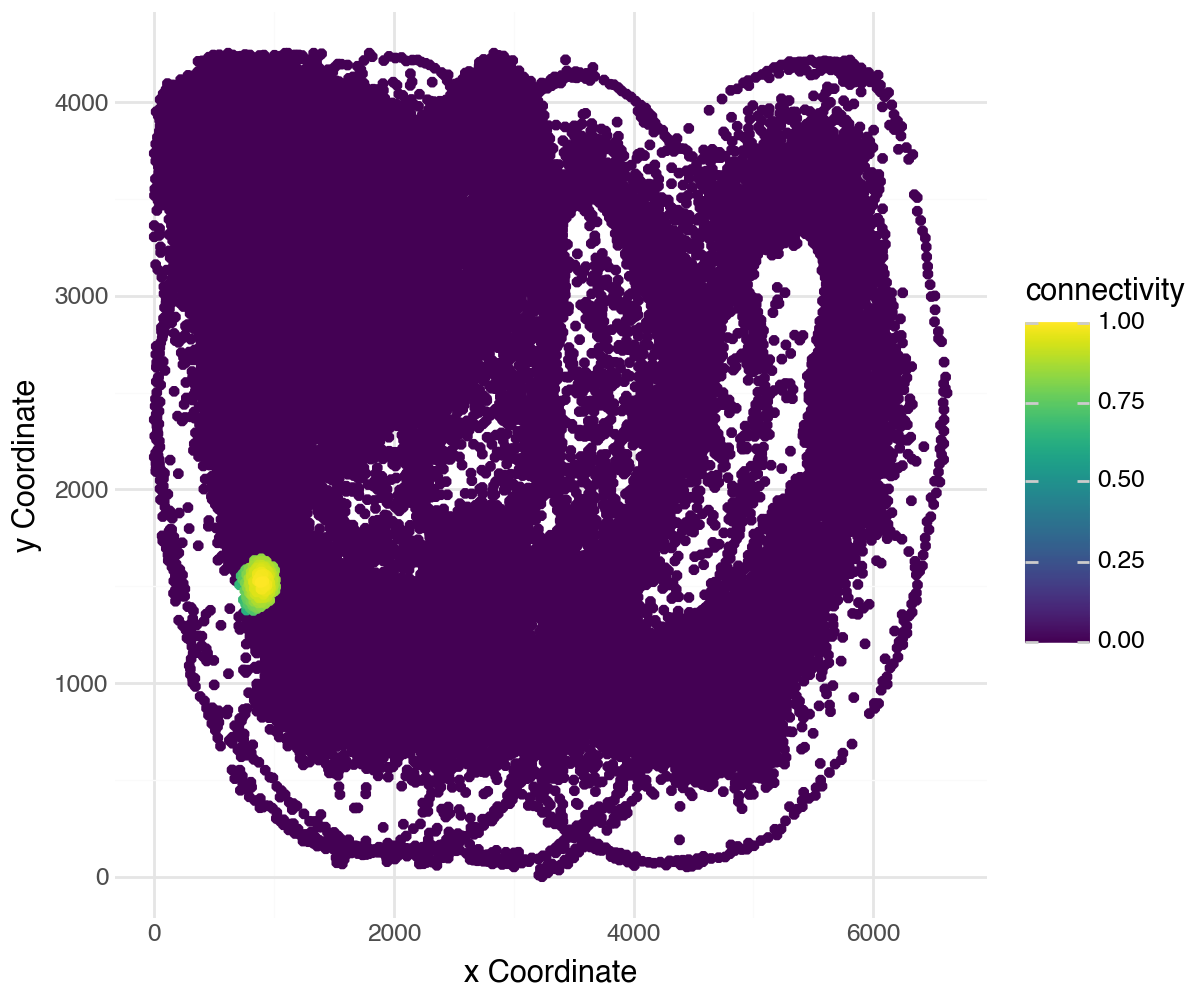

In [11]:
li.pl.connectivity(scRNA, idx=10000, size=1.3, figure_size=(6, 5))

In [12]:
# import requests
# import pandas as pd

# # Define the species and Ensembl server
# species = 'ambystoma_mexicanum'  # Example for axolotl
# ensembl_server = "https://rest.ensembl.org"

# # Fetch orthologs from Ensembl
# def fetch_orthologs(human_gene):
#     ext = f"/homology/id/{human_gene}?target_species={species}&type=orthologues"
#     r = requests.get(ensembl_server + ext, headers={"Content-Type": "application/json"})
#     if not r.ok:
#         r.raise_for_status()
#     return r.json()

# # Example: Fetch orthologs for a list of human genes
# human_genes = ['BRCA1', 'TP53', 'EGFR']  # Replace with your list
# orthologs = []
# for gene in human_genes:
#     data = fetch_orthologs(gene)
#     for homology in data['data'][0]['homologies']:
#         if homology['target']['species'] == species:
#             orthologs.append({
#                 'source': gene,
#                 'target': homology['target']['id']
#             })

# # Create a DataFrame for mapping
# map_df = pd.DataFrame(orthologs)
# print(map_df.head())


In [13]:
import liana as li
import pandas as pd

# Check if 'gene_symbol' column exists in scRNA.var
if 'gene_symbol' in scRNA.var.columns:
    print("Gene symbols found in 'gene_symbol' column.")
    scRNA.var_names = scRNA.var['gene_symbol']
else:
    print("No 'gene_symbol' column found. Please ensure your data has the correct gene symbols.")

# Check overlap with the resource
resource = li.resource.select_resource('consensus')
resource_genes = set(resource['ligand'].tolist() + resource['receptor'].tolist())
your_genes = set(scRNA.var_names.tolist())

intersection = resource_genes.intersection(your_genes)
print(f"Number of genes that match: {len(intersection)}")
print(f"Proportion matching: {len(intersection)/len(resource_genes):.3f}")

if len(intersection) == 0:
    print("No matching genes found. Consider converting your gene symbols to human gene symbols.")

No 'gene_symbol' column found. Please ensure your data has the correct gene symbols.
Number of genes that match: 658
Proportion matching: 0.326


In [14]:
scRNA.var_names

Index(['LOC101953204', 'AMEX60DD000005', 'LOC108803380', 'FZD10', 'PARPI_0010196', 'SLC15A4', 'TMEM132C', 'TMEM132B', 'AACS', 'BRI3BP',
       ...
       'CD44', 'AMEX60DDU001040377', 'AMEX60DDU001040439', 'CMTM8', 'AMEX60DDU001041052', 'OJAV_G00236990', 'AMEX60DDU001041346', 'AMEX60DDU001041390', 'MEA1-1', 'PRDM7-1'], dtype='object', length=12771)

In [15]:
lrdata = li.mt.bivariate(scRNA,
                resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                local_name='cosine', # Name of the function
                global_name="morans", # Name global function
                n_perms=100, # Number of permutations to calculate a p-value
                mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )

Using `.X`!


/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
['PARPI_0010196', 'SH_R122_JSM5CED3F', 'DV515_00011444', 'LLAP_20936', 'DR999_PMT16716', 'BN2614_LOCUS7', 'PARPI_0014279', 'PARPI_0014250', 'ADRBK2_3', 'D9C73_027807', 'AAES_142837', 'E2I00_017014', 'PARPI_0010863', 'PARPI_0003670', 'N338_02708', 'LLAP_10202', 'DR999_PMT18881', 'EOD39_7673', 'DR999_PMT16664', 'MONAX_5E042857', 'E1301_TTI003913', 'CIB84_006855', 'PARPI_0000285', 'AB2

In [16]:
lrdata

AnnData object with n_obs × n_vars = 28757 × 38
    obs: 'CellID', 'day', 'cell_id', 'celltype', 'color'
    var: 'ligand', 'receptor', 'ligand_means', 'ligand_props', 'receptor_means', 'receptor_props', 'morans', 'morans_pvals', 'mean', 'std'
    uns: 'hvg', 'neighbors', 'pca', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'cats', 'pvals'
    obsp: 'connectivities', 'distances', 'spatial_connectivities'

In [17]:
(lrdata.var.sort_values("mean", ascending=False))

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,morans,morans_pvals,mean,std
interaction,,,,,,,,,,
L1CAM^CNTN1,L1CAM,CNTN1,1.242858,0.578607,1.207528,0.563897,0.046141,0.00,0.625090,0.144257
CNTN1^NRCAM,CNTN1,NRCAM,1.207528,0.563897,0.852256,0.418263,0.043111,0.00,0.536806,0.143174
CNTN1^PTPRZ1,CNTN1,PTPRZ1,1.207528,0.563897,0.993584,0.482665,-0.006024,0.00,0.532908,0.131584
L1CAM^PTPRZ1,L1CAM,PTPRZ1,1.242858,0.578607,0.993584,0.482665,-0.017371,0.00,0.519375,0.141357
PSAP^SORT1,PSAP,SORT1,1.654053,0.716973,0.637703,0.335570,0.018748,0.00,0.497477,0.131031
NPTX2^NPTXR,NPTX2,NPTXR,0.599981,0.278889,1.804460,0.681260,0.188969,0.00,0.494290,0.241730
PTN^PTPRZ1,PTN,PTPRZ1,0.738616,0.344716,0.993584,0.482665,0.042571,0.00,0.417518,0.187034
GNAI2^CNR1,GNAI2,CNR1,0.808774,0.407727,0.657251,0.322565,0.048579,0.00,0.401114,0.172923
RGMA^NEO1,RGMA,NEO1,0.678832,0.351358,0.772260,0.399972,0.027086,0.00,0.389996,0.150597


... storing 'ligand' as categorical
... storing 'receptor' as categorical


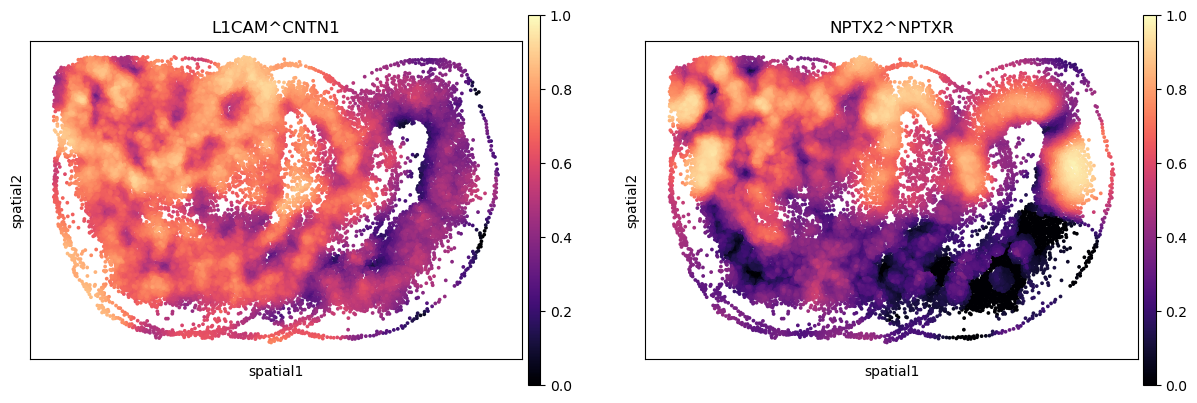

In [18]:
# Provide spot_size directly
sc.pl.spatial(lrdata, color=['L1CAM^CNTN1', 'NPTX2^NPTXR'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed

In [19]:
# # for all the days

# li.method.rank_aggregate(
#     adata=scRNA,
#     groupby='celltype',
#     resource_name='consensus',
#     use_raw=False,         # <--- add this line
#     verbose=True
# )

lrdata_by_day= []
nz_prop= 0.1
for stage in scRNA.obs['day'].unique():
    adata_stage = scRNA[scRNA.obs['day'] == stage].copy()
    lrdata = li.mt.bivariate(adata_stage,
                resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                local_name='cosine', # Name of the function
                global_name="morans", # Name global function
                n_perms=100, # Number of permutations to calculate a p-value
                mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=nz_prop, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )
    # Save or analyze results for this stage
    # adata_stage.uns['liana_res'].to_csv(f'liana_results_stage_{stage}.csv')
    lrdata_by_day.append(lrdata)



Using `.X`!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
['PARPI_0010196', 'SH_R122_JSM5CED3F', 'DV515_00011444', 'LLAP_20936', 'DR999_PMT16716', 'BN2614_LOCUS7', 'PARPI_0014279', 'PARPI_0014250', 'ADRBK2_3', 'D9C73_027807', 'AAES_142837', 'E2I00_017014', 'PARPI_0010863', 'PARPI_0003670', 'N338_02708', 'LLAP_10202', 'DR999_PMT18881', 'EOD39_7673', 'DR999_PMT16664', 'MONAX_5E042857', 'E1301_TTI003913', 'CIB84_006855', 'PARPI_0000285', 'AB205_0008660', 'EGK_18751', 'AB205_0215530', 'DR999_PMT13142', 'DR999_PMT13145', 'N337_12363', 'DR999_PMT13176', 'DR999_PMT08429', 'DUI87_25391', 'DR999_PMT05315', 'AV530_007983', 'PARPI_0018606', 'H355_007947', 'CIB84_010776', 'ASZ78_001691', 'EOD39_8906', 'CIB84_010863', 'DR999_PMT03247', 'DR999_PMT03316', 'CCH79_00014362', 'XELAEV_18016697MG', 'D4764_14G0004430', 'DR999_PMT16250', 'DR999_PMT14834', 'PARPI_

In [20]:
for lrdata in lrdata_by_day:
    # print(lrdata.var.sort_values("mean", ascending=False))
    print(len(lrdata.var.sort_values("mean", ascending=False)))

# for stage in scRNA.obs['day'].unique():
#     adata_stage = scRNA[scRNA.obs['day'] == stage].copy()
#     print(adata_stage.X.shape)

27
250
296
32
109


In [31]:
lrdata_by_day[2].var.sort_values("mean", ascending=False)

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,morans,morans_pvals,mean,std
interaction,,,,,,,,,,
L1CAM^CNTN1,L1CAM,CNTN1,1.356208,0.813605,1.359224,0.825850,0.342612,0.00,0.847428,0.147165
CNTN1^PTPRZ1,CNTN1,PTPRZ1,1.359224,0.825850,1.334870,0.830839,-0.129849,0.00,0.802730,0.085775
L1CAM^PTPRZ1,L1CAM,PTPRZ1,1.356208,0.813605,1.334870,0.830839,-0.179705,0.00,0.787146,0.114562
CNTN1^NRCAM,CNTN1,NRCAM,1.359224,0.825850,1.025020,0.660771,0.296531,0.00,0.764945,0.175927
PSAP^SORT1,PSAP,SORT1,1.750647,0.975057,0.902238,0.632200,0.012701,0.00,0.758066,0.071447
RGMA^NEO1,RGMA,NEO1,1.008123,0.691837,1.153381,0.769615,0.041898,0.00,0.698838,0.123136
NCAN^SDC3,NCAN,SDC3,0.874352,0.632426,1.186347,0.770748,0.133382,0.00,0.688370,0.175768
PTN^PTPRZ1,PTN,PTPRZ1,1.055167,0.639909,1.334870,0.830839,0.120660,0.00,0.688342,0.178191
LGI2^ADAM22,LGI2,ADAM22,1.000813,0.711565,1.050097,0.703628,-0.079307,0.00,0.676141,0.104441


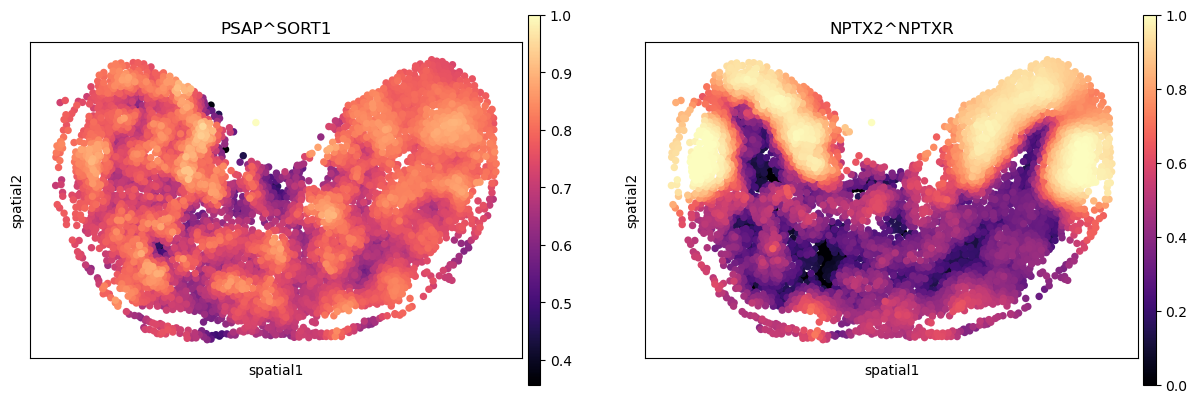

In [ ]:
# sc.pl.spatial(lrdata_by_day[2], color=['L1CAM^CNTN1', 'NPTX2^NPTXR'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed
# sc.pl.spatial(lrdata_by_day[2], color=['CNTN1^PTPRZ1', 'NPTX2^NPTXR'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed
sc.pl.spatial(lrdata_by_day[2], color=['LGALS1^ITGB1', 'NPTX2^NPTXR'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed


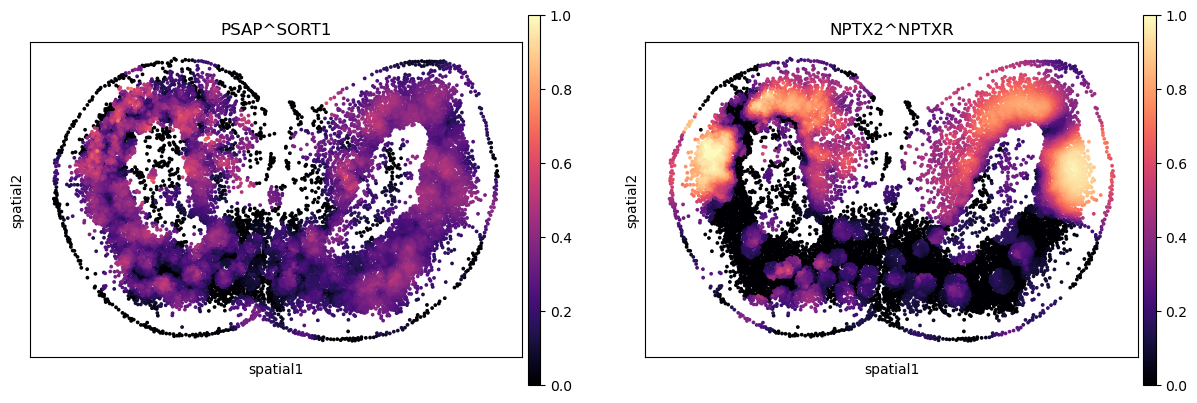

In [34]:
# sc.pl.spatial(lrdata_by_day[3], color=['L1CAM^CNTN1', 'NPTX2^NPTXR'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed
# sc.pl.spatial(lrdata_by_day[3], color=['CNTN1^PTPRZ1', 'NPTX2^NPTXR'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed
sc.pl.spatial(lrdata_by_day[3], color=['PSAP^SORT1', 'NPTX2^NPTXR'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed


In [24]:
lrdata_by_day[0]

AnnData object with n_obs × n_vars = 1477 × 27
    obs: 'CellID', 'day', 'cell_id', 'celltype', 'color'
    var: 'ligand', 'receptor', 'ligand_means', 'ligand_props', 'receptor_means', 'receptor_props', 'morans', 'morans_pvals', 'mean', 'std'
    uns: 'hvg', 'neighbors', 'pca', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'cats', 'pvals'
    obsp: 'connectivities', 'distances', 'spatial_connectivities'

In [25]:
def get_communication_matrix(adata, all_celltypes):

    communication_dict = {}
    liana_df = adata.uns['liana_res']
    for celltype in all_celltypes:
        communication_dict[celltype] = []
        for celltype_2 in all_celltypes:
            if celltype in liana_df['source'].unique() and celltype_2 in liana_df['target'].unique():
                communication_dict[celltype].append(liana_df[(liana_df['source'] == celltype) & (liana_df['target'] == celltype_2)]['lrscore'].values.sum())
            else:
                communication_dict[celltype].append(0)

    cc_comm_df= pd.DataFrame(communication_dict, index=all_celltypes, columns=all_celltypes)

    return cc_comm_df

In [26]:
import pandas as pd
import numpy as np
from scipy import sparse

# Step 1: Collect all unique LR pairs across all time points
all_lr_pairs = set()
for lrdata in lrdata_by_day:
    all_lr_pairs.update(lrdata.var_names)

# Convert to sorted list for consistent ordering
all_lr_pairs = sorted(list(all_lr_pairs))
print(f"Total unique LR pairs across all time points: {len(all_lr_pairs)}")

# Step 2: Create LR_pattern feature vectors for each time point
for i, stage in enumerate(scRNA.obs['day'].unique()):
    # Get the subset of cells for this stage
    stage_mask = scRNA.obs['day'] == stage
    n_cells_stage = stage_mask.sum()
    
    # Initialize LR_pattern matrix with zeros
    lr_pattern_matrix = np.zeros((n_cells_stage, len(all_lr_pairs)))
    
    # Get the lrdata for this stage
    lrdata = lrdata_by_day[i]
    
    # Convert sparse matrix to dense if needed
    if sparse.issparse(lrdata.X):
        lrdata_dense = lrdata.X.toarray()
    else:
        lrdata_dense = lrdata.X
    
    # Fill in the values for LR pairs that exist in this stage
    for j, lr_pair in enumerate(all_lr_pairs):
        if lr_pair in lrdata.var_names:
            # Get the index of this LR pair in the current lrdata
            lr_idx = lrdata.var_names.get_loc(lr_pair)
            # Copy the values for all cells
            lr_pattern_matrix[:, j] = lrdata_dense[:, lr_idx]
        # If LR pair doesn't exist in this stage, it remains 0 (already initialized)
    
    # Add LR_pattern to obsm for cells of this stage
    if 'LR_pattern' not in scRNA.obsm:
        # Initialize the full LR_pattern matrix for all cells
        scRNA.obsm['LR_pattern'] = np.zeros((scRNA.n_obs, len(all_lr_pairs)))
    
    # Fill in the values for this stage
    scRNA.obsm['LR_pattern'][stage_mask] = lr_pattern_matrix
    
    print(f"Stage {stage}: {n_cells_stage} cells, {len(lrdata.var_names)} LR pairs available")

# Step 3: Add metadata about the LR pairs
scRNA.uns['LR_pattern_pairs'] = all_lr_pairs
print(f"LR_pattern matrix shape: {scRNA.obsm['LR_pattern'].shape}")
print(f"LR pair names stored in scRNA.uns['LR_pattern_pairs']")

Total unique LR pairs across all time points: 321
Stage 0: 1477 cells, 27 LR pairs available
Stage 1: 2929 cells, 250 LR pairs available
Stage 2: 4410 cells, 296 LR pairs available
Stage 3: 11698 cells, 32 LR pairs available
Stage 4: 8243 cells, 109 LR pairs available
LR_pattern matrix shape: (28757, 321)
LR pair names stored in scRNA.uns['LR_pattern_pairs']


In [27]:
scRNA

AnnData object with n_obs × n_vars = 28757 × 12771
    obs: 'CellID', 'day', 'cell_id', 'celltype', 'color'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'gene_symbol_original'
    uns: 'hvg', 'neighbors', 'pca', 'umap', 'log1p', 'LR_pattern_pairs'
    obsm: 'X_pca', 'X_umap', 'spatial', 'LR_pattern'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities'

In [28]:
scRNA.obsm['LR_pattern'].shape

(28757, 321)

In [29]:
len(all_lr_pairs)

321